In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
diagnoses_df = pd.read_csv('cleaned_D_ICD_DIAGNOSES.csv')
patients_df = pd.read_csv('cleaned_PATIENTS.csv')
prescriptions_df = pd.read_csv('cleaned_PRESCRIPTIONS.csv')

/var/folders/kw/fxbbvv5x7lvct1l7rdc18tkw0000gn/T/ipykernel_21113/3639269906.py:3: DtypeWarning: Columns (11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions_df = pd.read_csv('cleaned_PRESCRIPTIONS.csv')


In [3]:
diagnoses_df.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,tb pneumonia-oth test,"tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,tb pneumothorax-unspec,"tuberculous pneumothorax, unspecified"
2,176,01171,tb pneumothorax-no exam,"tuberculous pneumothorax, bacteriological or h..."
3,177,01172,tb pneumothorx-exam unkn,"tuberculous pneumothorax, bacteriological or h..."
4,178,01173,tb pneumothorax-micro dx,"tuberculous pneumothorax, tubercle bacilli fou..."


In [4]:
patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaN,NaN,NaN,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15,NaN,NaN,NaN,0
3,237,252,M,2078-03-06,NaN,NaN,NaN,0
4,238,253,F,2089-11-26,NaN,NaN,NaN,0


In [5]:
prescriptions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11,2175-06-12,MAIN,tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2.0,mg,2,CAP,po
1,2214775,6,107064,NaN,2175-06-11,2175-06-12,MAIN,warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5.0,mg,1,TAB,po
2,2216265,6,107064,NaN,2175-06-11,2175-06-12,BASE,d5w,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250.0,ml,250,ml,iv
3,2214773,6,107064,NaN,2175-06-11,2175-06-12,MAIN,furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20.0,mg,1,TAB,po
4,2214774,6,107064,NaN,2175-06-11,2175-06-15,MAIN,warfarin,Warfarin,Warfarin,WARF0,014198,56016975.0,Check with MD for Dose,1.0,dose,1,dose,po


In [6]:
prescriptions_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTDATE', 'ENDDATE',
       'DRUG_TYPE', 'DRUG', 'DRUG_NAME_POE', 'DRUG_NAME_GENERIC',
       'FORMULARY_DRUG_CD', 'GSN', 'NDC', 'PROD_STRENGTH', 'DOSE_VAL_RX',
       'DOSE_UNIT_RX', 'FORM_VAL_DISP', 'FORM_UNIT_DISP', 'ROUTE'],
      dtype='object')

In [7]:
prescriptions_df["DRUG"].nunique()

3798

In [8]:
prescriptions_df["DRUG_TYPE"].describe()

count     3859168
unique          3
top          MAIN
freq      2930412
Name: DRUG_TYPE, dtype: object

In [9]:
prescriptions_df["DRUG_NAME_GENERIC"].nunique()

2832

In [10]:
prescriptions_df["DRUG_NAME_POE"].nunique()


3916

In [11]:
prescriptions_df["FORMULARY_DRUG_CD"].nunique()


3241

In [12]:
prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE'])
prescriptions_df['ENDDATE'] = pd.to_datetime(prescriptions_df['ENDDATE'])
prescriptions_df['DURATION'] = (prescriptions_df['ENDDATE'] - prescriptions_df['STARTDATE']).dt.days

# Merge datasets
merged_df = pd.merge(patients_df[['SUBJECT_ID', 'EXPIRE_FLAG']], prescriptions_df[['SUBJECT_ID', 'DRUG_NAME_GENERIC', 'DRUG_TYPE', 'DRUG', 'DURATION', 'NDC']], on='SUBJECT_ID')

In [13]:
merged_df.isna().sum()

SUBJECT_ID                 0
EXPIRE_FLAG                0
DRUG_NAME_GENERIC    1595328
DRUG_TYPE                  0
DRUG                       0
DURATION                   0
NDC                     3057
dtype: int64

In [14]:
merged_df.dropna(subset=['NDC'], inplace=True)
merged_df.shape

(3856111, 7)

In [15]:
merged_df.dtypes

SUBJECT_ID             int64
EXPIRE_FLAG            int64
DRUG_NAME_GENERIC     object
DRUG_TYPE             object
DRUG                  object
DURATION               int64
NDC                  float64
dtype: object

In [16]:
merged_df['NDC'] = merged_df['NDC'].astype(int)

In [17]:
# Step 1: Convert to string
merged_df['NDC'] = merged_df['NDC'].astype(str)

# Step 2: Pad with leading zeros to ensure length is 10
merged_df['NDC'] = merged_df['NDC'].apply(lambda x: x.zfill(10))

# Step 3: Count entries of length 11
entries_length_11 = merged_df[merged_df['NDC'].str.len() == 11].shape[0]

# Step 4: Drop entries of length 11
merged_df = merged_df[merged_df['NDC'].str.len() <= 10]

# Display the count of entries that were of length 11 and dropped
print(f"Number of entries of length 11 and dropped: {entries_length_11}")

Number of entries of length 11 and dropped: 928315


In [18]:
# ensure it's a copy to avoid SettingWithCopyWarning
merged_df = merged_df.copy()

# Now, safely reformat the "NDC" column values without triggering the warning
merged_df['NDC'] = merged_df['NDC'].apply(lambda x: f"{x[:4]}-{x[4:8]}-{x[8:]}")

In [19]:
merged_df["NDC"].describe()

count          2927796
unique            2615
top       0000-0000-00
freq            577126
Name: NDC, dtype: object

In [20]:
merged_df.shape

(2927796, 7)

In [21]:
merged_df.head()

,SUBJECT_ID,EXPIRE_FLAG,DRUG_NAME_GENERIC,DRUG_TYPE,DRUG,DURATION,NDC
0,249,0,Trandolapril,MAIN,trandolapril,0,0074-2278-11
1,249,0,NaN,BASE,d5w,1,0000-0000-00
2,249,0,NaN,MAIN,vancomycin hcl,1,0002-7355-01
3,249,0,NaN,BASE,iso-osmotic dextrose,1,0000-0000-00
4,249,0,Captopril,MAIN,captopril,2,0003-0450-51


In [22]:
drug_code = pd.read_csv("ndc_map 2020_06_17 (atc5 atc4 ingredients).csv", low_memory=False)
drug_code.head()

,ndc,rxcui,atc4,atc4_name,in_rxcui,has_min,in_tty,in_name,in_synonym,in_umlscui,atc5,ddd,u,adm_r,whocc_note
0,0002-0800-01,540930.0,NaN,NaN,11295.0,False,IN,water,NaN,C0043047,NaN,NaN,NaN,NaN,NaN
1,0002-1200-30,1716302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0002-1200-50,1716302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0002-1210-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0002-1210-50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
merged_df = pd.merge(merged_df, drug_code, left_on='NDC', right_on='ndc', how='left')

In [24]:
merged_df.dropna(subset=["atc4", "atc4_name", 'atc5'], inplace=True)

In [25]:
merged_df.drop(["ndc", "ddd", "u", "adm_r", "whocc_note"], axis=1, inplace=True, errors='ignore')

In [26]:
merged_df.isna().sum()

SUBJECT_ID                 0
EXPIRE_FLAG                0
DRUG_NAME_GENERIC    2930623
DRUG_TYPE                  0
DRUG                       0
DURATION                   0
NDC                        0
rxcui                      0
atc4                       0
atc4_name                  0
in_rxcui                   0
has_min                    0
in_tty                     0
in_name                    0
in_synonym           3736047
in_umlscui                 0
atc5                       0
dtype: int64

In [27]:
merged_df.shape

(3761158, 17)

In [28]:
merged_df.head()

,SUBJECT_ID,EXPIRE_FLAG,DRUG_NAME_GENERIC,DRUG_TYPE,DRUG,DURATION,NDC,rxcui,atc4,atc4_name,in_rxcui,has_min,in_tty,in_name,in_synonym,in_umlscui,atc5
12,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,A12CA,Sodium,9863.0,False,IN,sodium chloride,NaN,C0037494,A12CA01
13,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,B05CB,Salt solutions,9863.0,False,IN,sodium chloride,NaN,C0037494,B05CB01
14,249,0,NaN,BASE,ns,1,0338-0049-38,1807632.0,B05XA,Electrolyte solutions,9863.0,False,IN,sodium chloride,NaN,C0037494,B05XA03
16,249,0,NaN,MAIN,humulin-r insulin,1,0002-8215-01,311036.0,A10AB,"Insulins and analogues for injection, fast-acting",253182.0,False,IN,"insulin, regular, human",NaN,C0795635,A10AB01
17,249,0,NaN,MAIN,humulin-r insulin,1,0002-8215-01,311036.0,A10AC,"Insulins and analogues for injection, intermed...",253182.0,False,IN,"insulin, regular, human",NaN,C0795635,A10AC01


In [29]:
merged_df["SUBJECT_ID"].nunique()

37619

In [30]:
merged_df['atc3'] = merged_df['atc4'].str[:4]
merged_df['atc2'] = merged_df['atc4'].str[:3]
merged_df['atc1'] = merged_df['atc4'].str[0]

In [32]:
print(merged_df["atc5"].nunique())
print(merged_df["atc4"].nunique())
print(merged_df["atc3"].nunique())
print(merged_df["atc2"].nunique())
print(merged_df["atc1"].nunique())

611
312
141
73
14


In [33]:
merged_df["atc4_name"].nunique()

287

In [34]:
merged_df.to_csv('./cleaned_drug_atc_expire.csv', index=False)

In [16]:
# sns.scatterplot(data=merged_df, x='DURATION', y='EXPIRE_FLAG')
# plt.xlabel('Duration of Prescription (Days)')
# plt.ylabel('Mortality Flag (1 for deceased)')
# plt.title('Correlation between Prescription Duration and Mortality')
# plt.show()

In [17]:
# sns.boxplot(x='EXPIRE_FLAG', y='DURATION', data=merged_df)
# plt.xlabel('Mortality Flag (1 for deceased)')
# plt.ylabel('Duration of Prescription (Days)')
# plt.title('Prescription Duration by Mortality Outcome')
# plt.show()

In [19]:
# survived = merged_df[merged_df['EXPIRE_FLAG'] == 0]['DURATION']
# deceased = merged_df[merged_df['EXPIRE_FLAG'] == 1]['DURATION']
# 
# sns.kdeplot(survived, label='Survived', shade=True)
# sns.kdeplot(deceased, label='Deceased', shade=True)
# plt.xlabel('Duration of Prescription (Days)')
# plt.ylabel('Density')
# plt.title('Density Plot of Prescription Duration by Mortality Outcome')
# plt.legend()
# plt.show()

In [20]:
# # Convert 'DRUG' column to categorical and get dummy variables
# drug_dummies = pd.get_dummies(merged_df['DRUG'])
# merged_with_dummies_df = pd.concat([merged_df, drug_dummies], axis=1)
# 
# # Ensure that we only include numeric columns for the correlation matrix
# numeric_columns = merged_with_dummies_df.select_dtypes(include=['number']).drop(["SUBJECT_ID"], axis=1)
# 
# # Calculate the correlation matrix
# correlation_matrix = numeric_columns.corr()
# 
# # Plot the heatmap
# sns.heatmap(correlation_matrix, annot=False)  # annot=True can be overwhelming with many variables
# plt.title('Heatmap of Drug Types and Mortality Correlation')
# plt.show()

In [105]:
drug_expire = pd.read_csv('cleaned_drug_atc_expire.csv')

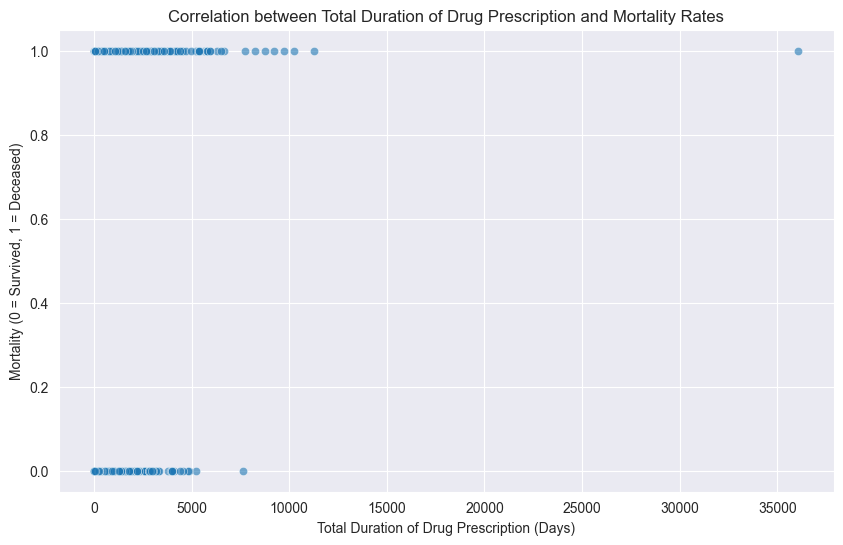

0.12641865829313695

In [106]:
# Aggregate the total duration of drug prescriptions per patient
patient_duration = drug_expire.groupby('SUBJECT_ID')['DURATION'].sum().reset_index()

# Merge this with the mortality flag to get a dataframe suitable for correlation analysis
mortality_duration = patient_duration.merge(drug_expire[['SUBJECT_ID', 'EXPIRE_FLAG']].drop_duplicates(), on='SUBJECT_ID')

# Scatter plot for correlation between the total duration of drug prescription and mortality rates
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mortality_duration, x='DURATION', y='EXPIRE_FLAG', alpha=0.6)
plt.title('Correlation between Total Duration of Drug Prescription and Mortality Rates')
plt.xlabel('Total Duration of Drug Prescription (Days)')
plt.ylabel('Mortality (0 = Survived, 1 = Deceased)')
plt.grid(True)
plt.show()

# Calculate the correlation coefficient for duration and expire flag
correlation_coef = mortality_duration['DURATION'].corr(mortality_duration['EXPIRE_FLAG'])
correlation_coef

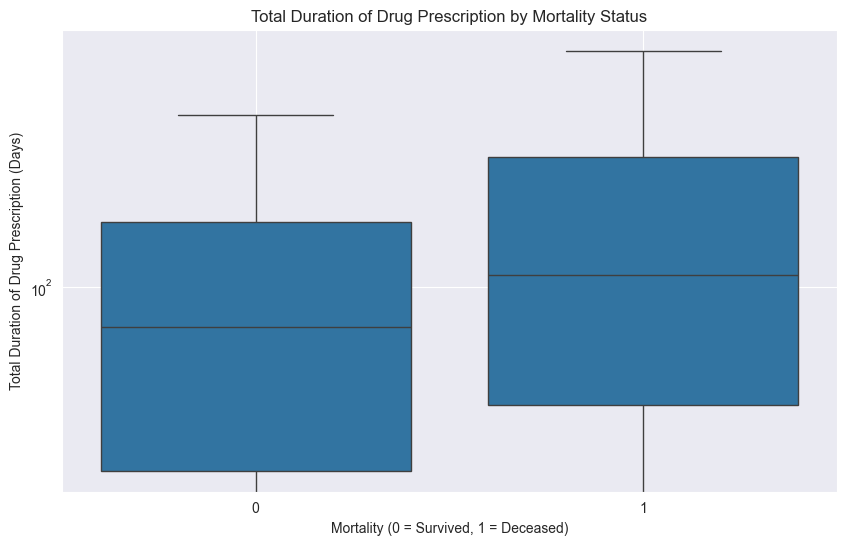

In [107]:
# Aggregate the total duration of drug prescriptions per patient
patient_duration = drug_expire.groupby('SUBJECT_ID')['DURATION'].sum().reset_index()

# Merge this with the mortality flag to get a dataframe suitable for correlation analysis
mortality_duration = patient_duration.merge(drug_expire[['SUBJECT_ID', 'EXPIRE_FLAG']].drop_duplicates(), on='SUBJECT_ID')

# Create a boxplot with log scale
plt.figure(figsize=(10, 6))
sns.boxplot(data=mortality_duration, x='EXPIRE_FLAG', y='DURATION', showfliers=False)
plt.yscale('log')  # Set y-axis to log scale
plt.title('Total Duration of Drug Prescription by Mortality Status')
plt.xlabel('Mortality (0 = Survived, 1 = Deceased)')
plt.ylabel('Total Duration of Drug Prescription (Days)')
plt.grid(True)
plt.show()

In [125]:
drug_class = 'atc4_name'

In [126]:
# The goal is to have each entry include patient ID, drug information, total duration of that particular drug, and the number of times this drug prescribed to this patient.

# Grouping the data by 'SUBJECT_ID' and 'DRUG_NAME_GENERIC' to aggregate the total duration and count the prescriptions
drug_patient_summary = drug_expire.groupby(['SUBJECT_ID', drug_class]).agg(
    Total_Duration=('DURATION', 'sum'),
    Prescription_Count=('atc4', 'count')
).reset_index()

# Merging the summary data back with the original to include 'EXPIRE_FLAG'
drug_patient_complete = pd.merge(
    drug_patient_summary,
    drug_expire[['SUBJECT_ID', drug_class, 'EXPIRE_FLAG']].drop_duplicates(),
    on=['SUBJECT_ID', drug_class],
    how='left'
)

# Now, proceed with the analysis similar to before, focusing on the top drugs but considering the newly structured data
# Selecting the top 10 most frequently prescribed drugs
top_drugs = drug_patient_complete[drug_class].value_counts().head(40).index.tolist()

# Filter the dataset to include only the top drugs
top_drugs_df = drug_patient_complete[drug_patient_complete[drug_class].isin(top_drugs)]

# Aggregate data by drug and mortality flag, summing the total duration and counting the number of prescriptions
drug_mortality_summary = top_drugs_df.groupby([drug_class, 'EXPIRE_FLAG']).agg(
    Total_Duration=('Total_Duration', 'sum'),
    Prescription_Count=('Prescription_Count', 'sum')
).unstack(fill_value=0)

# Calculate the mortality rate as before
drug_mortality_summary['Mortality Rate'] = drug_mortality_summary[('Prescription_Count', 1)] / (
    drug_mortality_summary[('Prescription_Count', 0)] + drug_mortality_summary[('Prescription_Count', 1)]
)

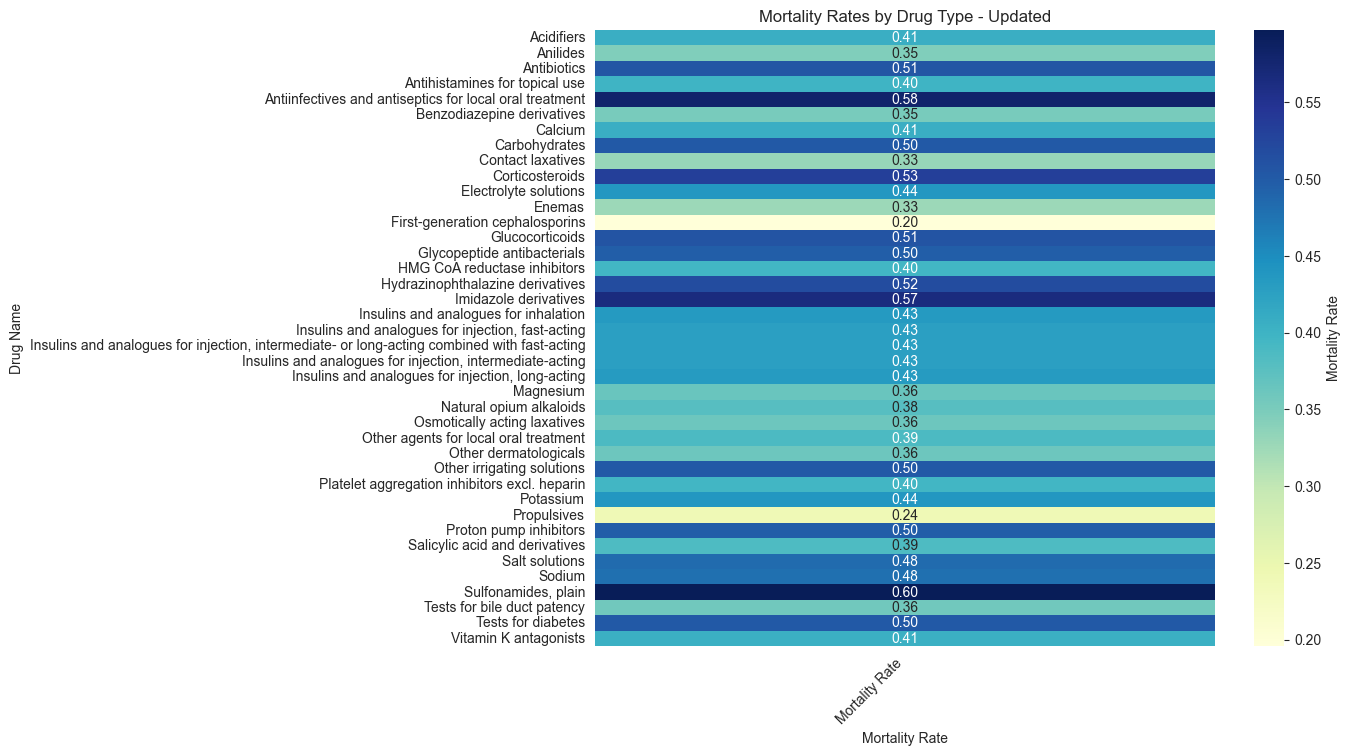

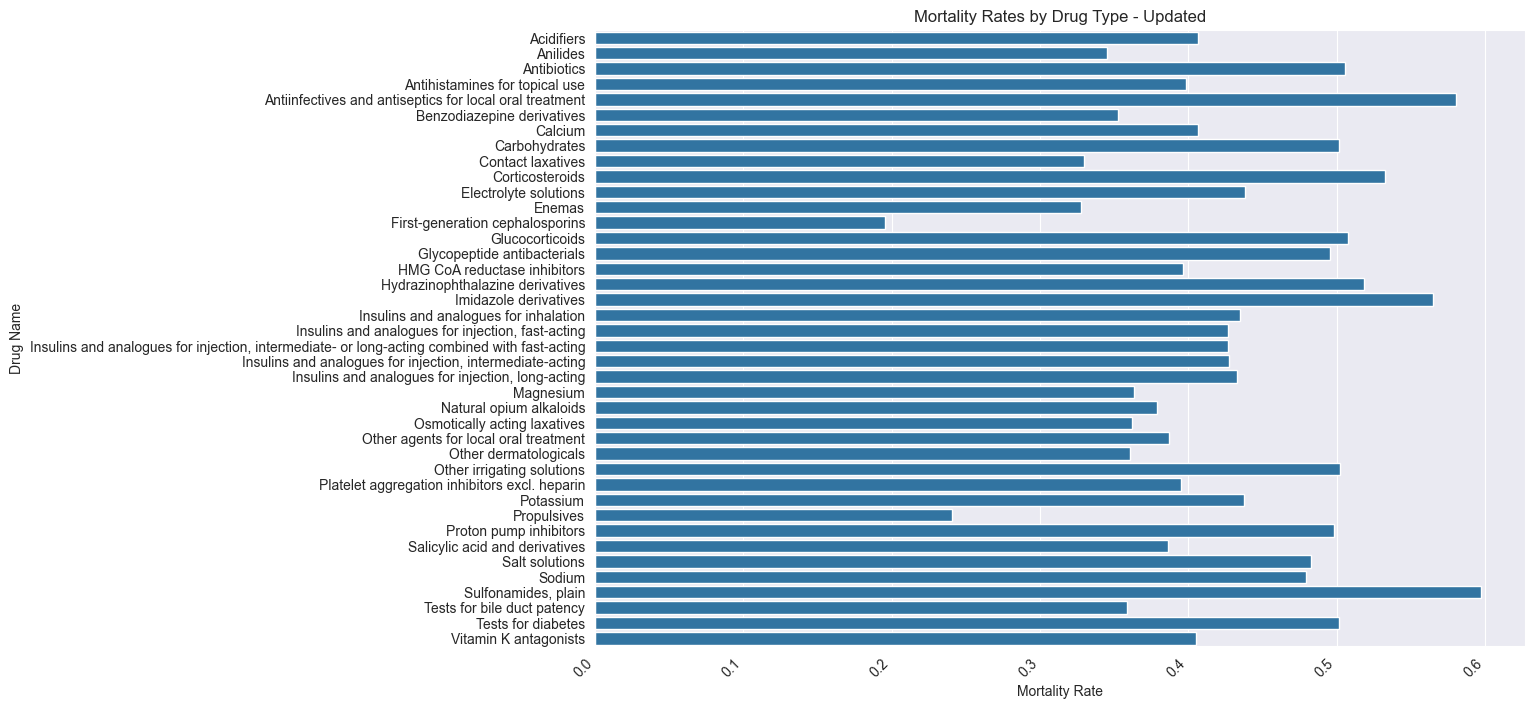

In [128]:
# Preparing data for the visualizations
heatmap_data = drug_mortality_summary[['Mortality Rate']].reset_index()
heatmap_data.columns = [drug_class, 'Mortality Rate']
heatmap_data.set_index(drug_class, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data=heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'}, fmt=".2f")
plt.title('Mortality Rates by Drug Type - Updated')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plotting the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Mortality Rate', y=drug_class, data=heatmap_data.reset_index())
plt.title('Mortality Rates by Drug Type - Updated')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

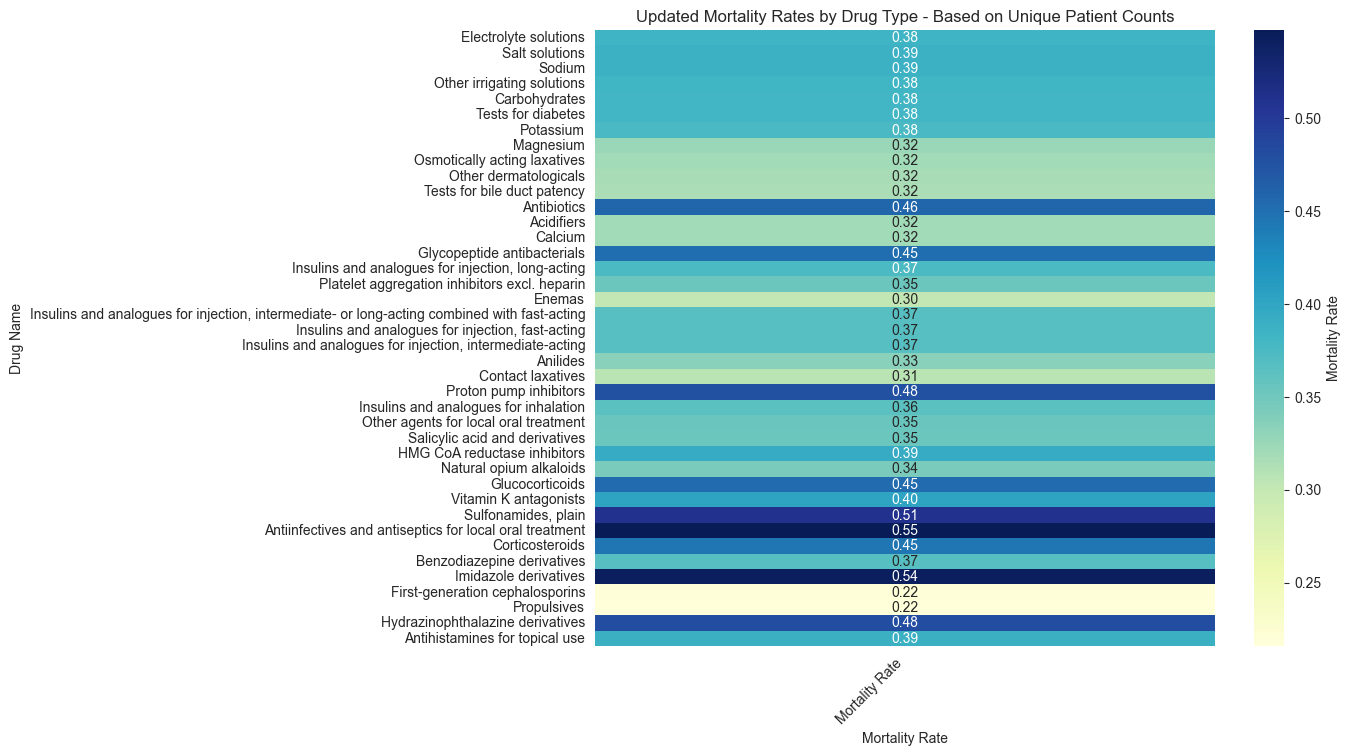

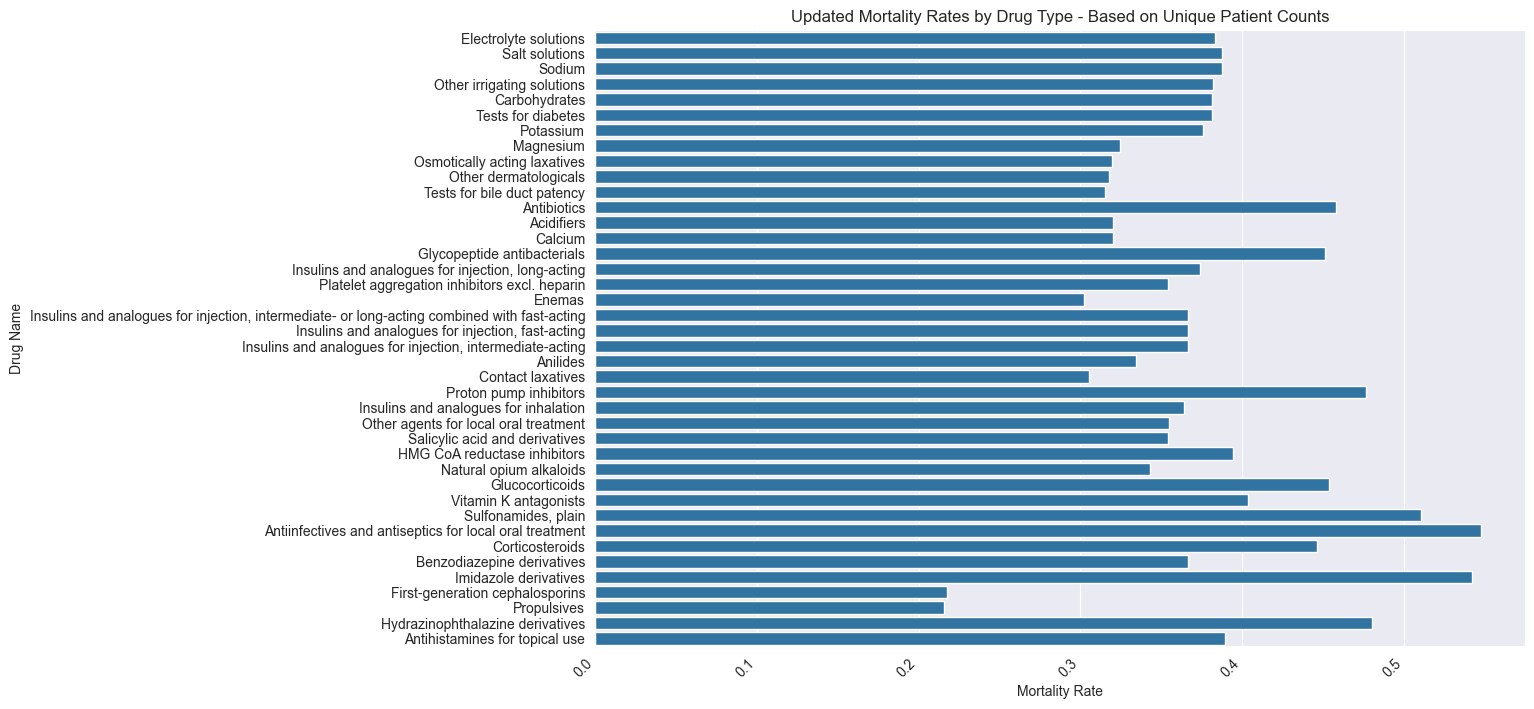

In [129]:
# First, calculating unique patients per drug and their expiration status
unique_patient_drug_expire = drug_patient_complete.groupby([drug_class, 'EXPIRE_FLAG'])['SUBJECT_ID'].nunique().unstack(fill_value=0)

# Calculate the new mortality rate based on unique patient counts
unique_patient_drug_expire['Mortality Rate'] = unique_patient_drug_expire[1] / (unique_patient_drug_expire[0] + unique_patient_drug_expire[1])

# Preparing the visualization data, focusing on the top drugs
new_heatmap_data = unique_patient_drug_expire.loc[top_drugs, ['Mortality Rate']]

# Plotting the heatmap for the updated mortality rates
plt.figure(figsize=(10, 8))
sns.heatmap(data=new_heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'}, fmt=".2f")
plt.title('Updated Mortality Rates by Drug Type - Based on Unique Patient Counts')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plotting the bar chart for the updated mortality rates
plt.figure(figsize=(12, 8))
sns.barplot(x='Mortality Rate', y=new_heatmap_data.reset_index()[drug_class], data=new_heatmap_data.reset_index())
plt.title('Updated Mortality Rates by Drug Type - Based on Unique Patient Counts')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

In [121]:
heatmap_data.head()

,Mortality Rate
atc4,
A01AB,0.580481
A01AD,0.387093
A02BC,0.498030
A03FA,0.240547
A06AB,0.330010


In [122]:
drug_patient_complete

,SUBJECT_ID,atc4,Total_Duration,Prescription_Count,EXPIRE_FLAG
0,4,A10AE,11,9,0
1,4,A12CA,3,1,0
2,4,B05CB,3,1,0
3,4,B05CX,3,3,0
4,4,B05XA,3,1,0
...,...,...,...,...,...
814035,99999,S01HA,1,1,0
814036,99999,S02DA,1,1,0
814037,99999,V04CA,5,1,0
814038,99999,V04CC,2,4,0


In [123]:
drug_mortality_summary[('Prescription_Count', 1)] 

atc4
A01AB      5478
A01AD      6610
A02BC      9859
A03FA      1883
A06AB      5494
A06AD     18811
A06AG      5606
A07AA     26693
A10AB     12862
A10AC     12847
A10AD     12862
A10AE     21691
A10AF     10252
A12AA     17657
A12BA     59040
A12CA    161694
A12CC     18435
B01AA     15940
B01AC      7956
B05CB    168557
B05CX    108793
B05XA    385023
C02DB      6765
C03CA     14111
C10AA      7106
D11AX     17823
G01AF      4882
G04BA     17657
H02AB     11317
J01DB      1775
J01XA     25588
N02AA      9598
N02BA      6517
N02BE      6097
N05BA      4927
R01AD      5194
S01AA     29367
V04CA    105395
V04CC     17449
V06DC    105395
Name: (Prescription_Count, 1), dtype: int64

In [31]:
# Selecting the top 10 most frequently prescribed drugs
top_drugs = drug_expire['DRUG_NAME_GENERIC'].value_counts().head(10).index.tolist()

# Filter the dataset to include only the top drugs
top_drugs_df = drug_expire[drug_expire['DRUG_NAME_GENERIC'].isin(top_drugs)]

# Preparing data for the heatmap
# We need to calculate the mortality rate for each drug
# First, aggregate data by drug and mortality flag, counting the number of prescriptions
drug_mortality = top_drugs_df.groupby(['DRUG_NAME_GENERIC', 'EXPIRE_FLAG']).size().unstack(fill_value=0)

# Calculate the mortality rate as the number of deceased patients (1) divided by the total number of prescriptions per drug
drug_mortality['Mortality Rate'] = drug_mortality[1] / (drug_mortality[0] + drug_mortality[1])

# Select only the mortality rate for the heatmap
heatmap_data = drug_mortality[['Mortality Rate']].reset_index()

# Pivot the data for the heatmap
heatmap_pivot = heatmap_data.pivot("DRUG_NAME_GENERIC", "DRUG_NAME_GENERIC", "Mortality Rate")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=heatmap_pivot, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'})
plt.title('Mortality Rates by Drug Type')
plt.xlabel('Drug Name')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()


TypeError: pivot() takes 1 positional argument but 4 were given

In [ ]:
# Selecting the top 10 most frequently prescribed drugs
top_drugs = drug_expire['DRUG_NAME_GENERIC'].value_counts().head(10).index.tolist()

# Filter the dataset to include only the top drugs
top_drugs_df = drug_expire[drug_expire['DRUG_NAME_GENERIC'].isin(top_drugs)]

# Preparing data for the heatmap
# We need to calculate the mortality rate for each drug
# First, aggregate data by drug and mortality flag, counting the number of prescriptions
drug_mortality = top_drugs_df.groupby(['DRUG_NAME_GENERIC', 'EXPIRE_FLAG']).size().unstack(fill_value=0)

# Calculate the mortality rate as the number of deceased patients (1) divided by the total number of prescriptions per drug
drug_mortality['Mortality Rate'] = drug_mortality[1] / (drug_mortality[0] + drug_mortality[1])

# Select only the mortality rate for the heatmap
heatmap_data = drug_mortality[['Mortality Rate']].reset_index()

# Pivot the data for the heatmap
heatmap_pivot = heatmap_data.pivot(index=0, columns='DRUG_NAME_GENERIC', values='Mortality Rate')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=heatmap_pivot, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'})
plt.title('Mortality Rates by Drug Type')
plt.xlabel('Drug Name')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
drug_expire2 = pd.read_csv('drug_expire.csv')

# Encoding drug names to numerical values for the heatmap
encoder = LabelEncoder()
drug_expire2['DRUG_ENCODED'] = encoder.fit_transform(drug_expire2['DRUG_NAME_GENERIC'])

# Creating a pivot table for the heatmap
heatmap_data = drug_expire2.pivot_table(values='DURATION', index='DRUG_ENCODED', columns='EXPIRE_FLAG', aggfunc='count', fill_value=0)

# Calculating correlation for the heatmap
corr = heatmap_data.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation between Drug Types and Mortality Rates')
plt.xlabel('Mortality (0: Survived, 1: Expired)')
plt.ylabel('Drug Types (Encoded)')
plt.show()
